In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import re
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('data/final_df.csv')

# Feature Engineering

In [3]:
# Drop Nulls in Temperature
df = df.dropna(subset=['weather_temperature'])

df['stadium_wind'] = np.where((df['stadium_capacity'] > 60000) & (df['weather_wind_mph'] > 14), 1, 0)


# Drop Uneeded Rows
df = df.drop(columns=['weather_humidity','weather_detail','stadium_address','stadium_weather_station_code',
                      'stadium_weather_type','STATION','ELEVATION','team_away','team_home','team_favorite_id',
                      'LATITUDE','LONGITUDE','zipcode','zipcode_away','stadium_name','home_OSRS','home_MoV',
                      'home_PD','away_OSRS','away_MoV','away_PD','schedule_season',
                      'away_DSRS','away_SRS','home_DSRS','home_SRS','diff_MoV','diff_SRS','diff_OSRS'])
 
df.drop(columns=['score_home','score_away', 'stadium_location','total'],inplace=True)
df.drop('schedule_date', axis=1,inplace=True)

# Transform Over/Under Results to Binary 0 = Under, 1 = Over
df['over_under_result'] = np.where(df['over_under_result'] == 'Over',1,0)
# Transform Stadium Surface to Binary 0 = Turf, 1 = Grass 
df['stadium_surface'] = np.where(df['stadium_surface'] == 'Grass',1,0)

# True/False to Binary 0 = False, 1 = True
df['schedule_playoff'] = list(map(int, df['schedule_playoff']))
df['stadium_neutral'] = list(map(int, df['stadium_neutral']))

# Get Dummies for Categorical Variables
df = pd.get_dummies(df, columns = ['stadium_type'], drop_first= True)
#df = pd.get_dummies(df, columns = ['stadium_name'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_home'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_away'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_favorite_id'], drop_first= True)

# Transform Uint8 values to Integers
uint8_columns = list(df.select_dtypes('uint8').columns)
for colname in df.columns:
    if colname in uint8_columns:
        df[colname] = df[colname].astype(int)

In [4]:
#df.columns[df.isnull().any()]
print(df.shape)
df.columns

(9229, 32)


Index(['schedule_week', 'schedule_playoff', 'spread_favorite',
       'over_under_line', 'stadium_neutral', 'weather_temperature',
       'weather_wind_mph', 'over_under_result', 'stadium_open',
       'stadium_capacity', 'stadium_surface', 'weekday', 'dist_diff',
       'home_W-L%', 'home_SoS', 'home_PF_per_game', 'home_PA_per_game',
       'away_W-L%', 'away_SoS', 'away_PF_per_game', 'away_PA_per_game',
       'home_superbowl_odds', 'away_superbowl_odds', 'diff_W-L%', 'diff_PD',
       'diff_SoS', 'diff_PF_per_game', 'diff_PA_per_game',
       'diff_superbowl_odds', 'stadium_wind', 'stadium_type_outdoor',
       'stadium_type_retractable'],
      dtype='object')

# Feature Selection

In [5]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('over_under_result', axis=1) # grabs everything else but 'Default'

# Create target variable
y = df['over_under_result'] # y is the column we're trying to predict

In [6]:
np.abs(df.corr()['over_under_result']).sort_values(ascending=False)

over_under_result           1.000000
stadium_wind                0.049312
weather_wind_mph            0.042514
dist_diff                   0.024960
over_under_line             0.024603
away_SoS                    0.022514
schedule_playoff            0.020958
home_PF_per_game            0.019480
away_W-L%                   0.018587
home_superbowl_odds         0.018313
home_W-L%                   0.016992
home_SoS                    0.015740
diff_PF_per_game            0.013017
diff_superbowl_odds         0.012394
stadium_surface             0.010890
home_PA_per_game            0.010857
diff_PA_per_game            0.010404
away_PA_per_game            0.010081
stadium_type_outdoor        0.009227
away_superbowl_odds         0.008871
schedule_week               0.007866
diff_PD                     0.006870
weather_temperature         0.006548
stadium_neutral             0.005854
spread_favorite             0.003775
away_PF_per_game            0.003331
stadium_capacity            0.003262
d

In [7]:
corrs_dict={}
for col in X.columns:
    corr=y.corr(X[col])
    corrs_dict[corr]=col
    
sorted(corrs_dict.items(),reverse=True)

[(0.024959650849576912, 'dist_diff'),
 (0.022514090111830865, 'away_SoS'),
 (0.020957789569271863, 'schedule_playoff'),
 (0.019479612998816506, 'home_PF_per_game'),
 (0.018587481184791466, 'away_W-L%'),
 (0.016992051946843473, 'home_W-L%'),
 (0.01301670680952392, 'diff_PF_per_game'),
 (0.010403729866683321, 'diff_PA_per_game'),
 (0.007865893597967018, 'schedule_week'),
 (0.006869868956956797, 'diff_PD'),
 (0.003774727577206224, 'spread_favorite'),
 (0.003331293964913058, 'away_PF_per_game'),
 (0.002356072500620278, 'diff_SoS'),
 (0.0017822791922111425, 'weekday'),
 (0.0015898280384689053, 'stadium_open'),
 (0.0001128461716924192, 'diff_W-L%'),
 (-0.0008809438689762755, 'stadium_type_retractable'),
 (-0.003262478666456242, 'stadium_capacity'),
 (-0.005853972909749411, 'stadium_neutral'),
 (-0.006547728777113998, 'weather_temperature'),
 (-0.008870867864243289, 'away_superbowl_odds'),
 (-0.009226500267294099, 'stadium_type_outdoor'),
 (-0.01008084428958728, 'away_PA_per_game'),
 (-0.0108

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_(X):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif['Features'] = X.columns
    return vif
Vif = vif_(X)

Vif.sort_values('VIF',ascending=False)[:5]

,VIF,Features
7,427.749614,stadium_open
3,136.667718,over_under_line
15,110.947861,home_PA_per_game
19,107.067065,away_PA_per_game
14,93.752495,home_PF_per_game


In [9]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(X)
poly2_columns = poly_2.get_feature_names(X.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
print(df_poly2.shape)
df_poly2.head()

(9229, 527)


,schedule_week,schedule_playoff,spread_favorite,over_under_line,stadium_neutral,weather_temperature,weather_wind_mph,stadium_open,stadium_capacity,stadium_surface,weekday,dist_diff,home_W-L%,home_SoS,home_PF_per_game,home_PA_per_game,away_W-L%,away_SoS,away_PF_per_game,away_PA_per_game,home_superbowl_odds,away_superbowl_odds,diff_W-L%,diff_PD,diff_SoS,diff_PF_per_game,diff_PA_per_game,diff_superbowl_odds,stadium_wind,stadium_type_outdoor,stadium_type_retractable,schedule_week^2,schedule_week schedule_playoff,schedule_week spread_favorite,schedule_week over_under_line,schedule_week stadium_neutral,schedule_week weather_temperature,schedule_week weather_wind_mph,schedule_week stadium_open,schedule_week stadium_capacity,schedule_week stadium_surface,schedule_week weekday,schedule_week dist_diff,schedule_week home_W-L%,schedule_week home_SoS,schedule_week home_PF_per_game,schedule_week home_PA_per_game,schedule_week away_W-L%,schedule_week away_SoS,schedule_week away_PF_per_game,...,away_superbowl_odds diff_PA_per_game,away_superbowl_odds diff_superbowl_odds,away_superbowl_odds stadium_wind,away_superbowl_odds stadium_type_outdoor,away_superbowl_odds stadium_type_retractable,diff_W-L%^2,diff_W-L% diff_PD,diff_W-L% diff_SoS,diff_W-L% diff_PF_per_game,diff_W-L% diff_PA_per_game,diff_W-L% diff_superbowl_odds,diff_W-L% stadium_wind,diff_W-L% stadium_type_outdoor,diff_W-L% stadium_type_retractable,diff_PD^2,diff_PD diff_SoS,diff_PD diff_PF_per_game,diff_PD diff_PA_per_game,diff_PD diff_superbowl_odds,diff_PD stadium_wind,diff_PD stadium_type_outdoor,diff_PD stadium_type_retractable,diff_SoS^2,diff_SoS diff_PF_per_game,diff_SoS diff_PA_per_game,diff_SoS diff_superbowl_odds,diff_SoS stadium_wind,diff_SoS stadium_type_outdoor,diff_SoS stadium_type_retractable,diff_PF_per_game^2,diff_PF_per_game diff_PA_per_game,diff_PF_per_game diff_superbowl_odds,diff_PF_per_game stadium_wind,diff_PF_per_game stadium_type_outdoor,diff_PF_per_game stadium_type_retractable,diff_PA_per_game^2,diff_PA_per_game diff_superbowl_odds,diff_PA_per_game stadium_wind,diff_PA_per_game stadium_type_outdoor,diff_PA_per_game stadium_type_retractable,diff_superbowl_odds^2,diff_superbowl_odds stadium_wind,diff_superbowl_odds stadium_type_outdoor,diff_superbowl_odds stadium_type_retractable,stadium_wind^2,stadium_wind stadium_type_outdoor,stadium_wind stadium_type_retractable,stadium_type_outdoor^2,stadium_type_outdoor stadium_type_retractable,stadium_type_retractable^2
0,1.0,0.0,3.0,30.0,0.0,79.0,9.0,1969.0,50000.0,1.0,5.0,1633.703354,0.313,-2.2,15.0625,16.1875,0.438,-1.2,18.1250,18.7500,25000.0,3500.0,0.125,8.0,1.0,3.0625,2.5625,21500.0,0.0,1.0,0.0,1.0,0.0,3.0,30.0,0.0,79.0,9.0,1969.0,50000.0,1.0,5.0,1633.703354,0.313,-2.2,15.0625,16.1875,0.438,-1.2,18.1250,...,8968.75,75250000.0,0.0,3500.0,0.0,0.015625,1.000,0.1250,0.382812,0.320312,2687.5,0.000,0.125,0.0,64.0,8.0,24.50,20.5000,172000.0,0.0,8.0,0.0,1.00,3.0625,2.5625,21500.0,0.0,1.0,0.0,9.378906,7.847656,65843.75,0.000,3.0625,0.0,6.566406,55093.75,0.00,2.5625,0.0,4.622500e+08,0.0,21500.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,5.0,39.0,0.0,74.0,15.0,1973.0,73967.0,0.0,6.0,1886.643589,0.313,0.0,18.8750,22.1250,0.688,0.2,23.2500,15.8750,30000.0,900.0,0.375,170.0,0.2,4.3750,6.2500,29100.0,1.0,1.0,0.0,1.0,0.0,5.0,39.0,0.0,74.0,15.0,1973.0,73967.0,0.0,6.0,1886.643589,0.313,0.0,18.8750,22.1250,0.688,0.2,23.2500,...,5625.00,26190000.0,900.0,900.0,0.0,0.140625,63.750,0.0750,1.640625,2.343750,10912.5,0.375,0.375,0.0,28900.0,34.0,743.75,1062.5000,4947000.0,170.0,170.0,0.0,0.04,0.8750,1.2500,5820.0,0.2,0.2,0.0,19.140625,27.343750,127312.50,4.375,4.3750,0.0,39.062500,181875.00,6.25,6.2500,0.0,8.468100e+08,29100.0,29100.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,3.0,31.0,0.0,78.0,11.0,1926.0,61500.0,1.0,6.0,293.605345,0.438,-1.1,15.8125,17.1250,0.531,0.7,15.5625,16.8125,4000.0,10000.0,0.093,1.0,1.8,0.2500,0.3125,6000.0,0.0,1.0,0.0,1.0,0.0,3.0,31.0,0.0,78.0,11.0,1926.0,61500.0,1.0,6.0,293.605345,0.438,-1.1,15.8125,17.1250,0.531,0.7,15.562

# Baseline Model

In [10]:
from sklearn.model_selection import KFold


In [11]:
#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_poly2, y,random_state=1)

In [12]:
# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = df_poly2.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = df_poly2.columns)

In [13]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight = 'balanced')

logreg.fit(X_train, y_train)

base_logred_train_pred = logreg.predict(X_train)
base_logred_test_pred = logreg.predict(X_test)

base_logred_train_f1_score = f1_score(y_train, base_logred_train_pred)
base_logreg_test_f1_score = f1_score(y_test, base_logred_test_pred)

print('Train F1 score: ', base_logred_train_f1_score)
print('Test F1 score: ', base_logreg_test_f1_score)


Train F1 score:  0.5908032596041909
Test F1 score:  0.5167755991285403


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


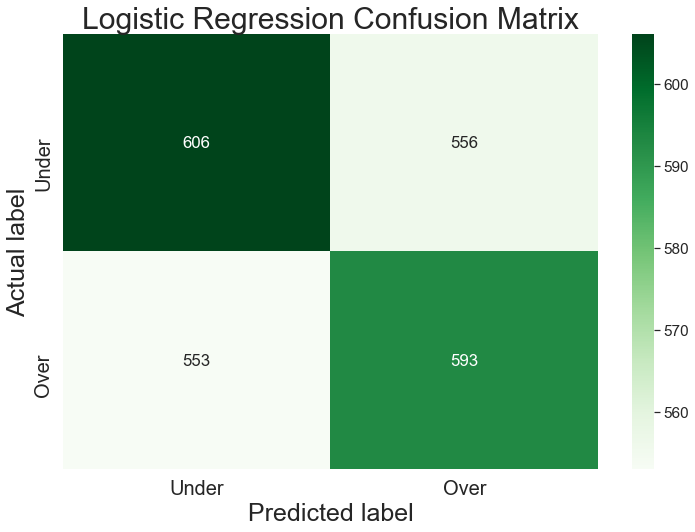

In [14]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, base_logred_test_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Logistic Regression Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
plt.savefig('log_confusion.png')

## Decision Tree

In [15]:
# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

clf = DecisionTreeClassifier(random_state=1, criterion = 'gini', max_depth = 6, min_samples_leaf = 6, min_samples_split = 6)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

clf_f1_train = round(f1_score(y_train, y_pred_train), 3)
clf_f1_test = round(f1_score(y_test, y_pred), 3)
clf_recall = round(metrics.recall_score(y_test, y_pred), 3)

print('Train F1 score: ', clf_f1_train)
print('Test F1 score: ', clf_f1_test)

Train F1 score:  0.413
Test F1 score:  0.334


In [16]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

ValueError: Length of passed values is 527, index implies 31.

In [ ]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['Over','Under'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

## Decision Tree w/ Gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
d_tree = DecisionTreeClassifier()
parameters = {"max_depth":range(15,25,1),
              "criterion":["entropy"], 
              "min_samples_leaf":range(50,80,5),
              "splitter":["best"],
              "max_features":range(1,28)}
d_tree_grid = GridSearchCV(d_tree,param_grid=parameters,scoring='f1',n_jobs=-1,cv=5,verbose=1)

In [ ]:
d_tree_grid.fit(X_train,y_train)

In [ ]:
print(d_tree_grid.best_score_)
print(d_tree_grid.best_params_)
print(d_tree_grid.best_estimator_)

In [ ]:
y_pred_d_tree_train = d_tree_grid.best_estimator_.predict(X_train)
y_pred_d_tree = d_tree_grid.best_estimator_.predict(X_test)

In [ ]:
gcv_decision_tree_recall_train = metrics.recall_score(y_train, y_pred_d_tree_train)
gcv_decision_tree_recall_score = metrics.recall_score(y_test, y_pred_d_tree)
gcv_decision_tree_f1_score = f1_score(y_test, y_pred_d_tree)
gcv_decision_tree_f1_train_score = f1_score(y_train, y_pred_d_tree_train)


print('Train F1 score: ', gcv_decision_tree_f1_train_score)
print('Test F1 score: ', gcv_decision_tree_f1_score)

In [ ]:
cm2 = confusion_matrix(y_test,y_pred_d_tree)
sns.heatmap(cm2,annot=True);

# Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)
rfc_predicted_train = rfc.predict(X_train)
rfc_recall_score = metrics.recall_score(y_test, rfc_predicted)

In [18]:
rfc_f1_train = round(f1_score(y_train, rfc_predicted_train), 3)
rfc_f1_test = round(f1_score(y_test, rfc_predicted), 3)

print('Train F1 score: ', rfc_f1_train)
print('Test F1 score: ', rfc_f1_test)

Train F1 score:  0.61
Test F1 score:  0.488


Text(0.5, 44.5, 'Predicted label')

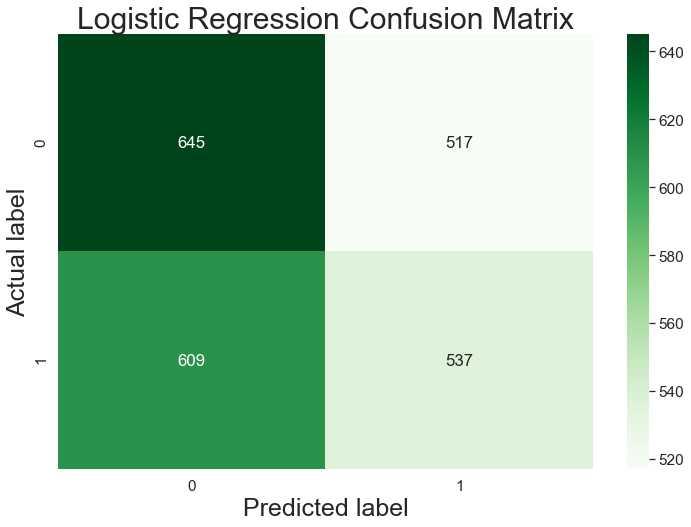

In [19]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, rfc_predicted, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Logistic Regression Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
#cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
#cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

In [30]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_train_pred = svc.predict(X_train)
svc_test_pred = svc.predict(X_test)

svc_train_f1_score = round(f1_score(y_train, svc_train_pred), 3)
svc_test_f1_score = round(f1_score(y_train, svc_test_pred), 3)

print('Train F1 score: ', svc_train_f1_score)
print('Test F1 score: ', svc_test_f1_score)

ValueError: Found input variables with inconsistent numbers of samples: [6921, 2308]